# DSSATTools Example 3: paralel simulations using threading

In this notebook you'll see the basic usage of DSSATools library to:
1. Create the inputs
2. Initialize the simulation environment
3. Run simulations in paralel
4. Modify input objects
5. Read outputs.

We'll use threading to run simulations in paralel. If you prefer to use Multiprocessing, i.e. different cores, the process is different since multiprocessing does not allows the modification of an instance.

In [1]:
from DSSATTools import (
    Crop, SoilProfile, WeatherData, WeatherStation,
    Management, DSSAT
)
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import threading
import os
from matplotlib import pyplot as plt

## Create a WeatherData instance

In [2]:
# Random weather data
DATES = pd.date_range('2000-01-01', '2001-12-31')
N = len(DATES)
df = pd.DataFrame(
    {
    'tn': np.random.gamma(15, 1, N),
    'rad': np.random.gamma(10, 1.5, N),
    'prec': [0.0]* N,
    'rh': 100 * np.random.beta(1.5, 1.15, N),
    },
    index=DATES,
)
df['TMAX'] = df.tn + abs(np.random.normal(5, 10, N))
df.head()

,tn,rad,prec,rh,TMAX
2000-01-01,24.037274,14.345314,0.0,81.462765,30.201274
2000-01-02,13.725123,7.799614,0.0,57.244678,36.844552
2000-01-03,14.724634,17.333881,0.0,60.592308,14.794443
2000-01-04,11.517067,17.743812,0.0,98.433912,39.658834
2000-01-05,17.514266,11.593904,0.0,71.166822,18.430770


In [3]:
# Create a WeatherData instance
WTH_DATA = WeatherData(
    df,
    variables={
        'tn': 'TMIN', 'TMAX': 'TMAX',
        'prec': 'RAIN', 'rad': 'SRAD',
        'rh': 'RHUM'
    }
)
# Create a WheaterStation instance
wth = WeatherStation(
    WTH_DATA, 
    {'ELEV': 33, 'LAT': 0, 'LON': 0, 'INSI': 'test'}
)

## Create a SoilProfile object from a default profile

In [4]:
# Soil instance from default soil profile
soil = SoilProfile(default_class='SICL')

## Create a Crop object from default crop file

In [5]:
# Crop
crop = Crop('sorghum')
# Check how the cultivar looks like
crop.cultivar['IB0001']

{'VAR-NAME........': 'RIO',
 'EXPNO': '.',
 'ECO#': 'IB0001',
 'P1': 430.0,
 'P2': 102.0,
 'P2O': 11.6,
 'P2R': 24.0,
 'PANTH': 617.5,
 'P3': 152.5,
 'P4': 81.5,
 'P5': 540.0,
 'PHINT': 49.0,
 'G1': 0.0,
 'G2': 6.0,
 'PBASE': None,
 'PSAT': None}

## Initialize one DSSAT instance per thread

In [6]:
dssat_envs = []
threads = 8
for n in range(threads):
    dssat_envs.append(DSSAT())
    dssat_envs[-1].setup()

/tmp/sdeadznw created.
Static files copied to /tmp/sdeadznw.
/tmp/zkfheexi created.
Static files copied to /tmp/zkfheexi.
/tmp/lxzjhpew created.
Static files copied to /tmp/lxzjhpew.
/tmp/enfxamlw created.
Static files copied to /tmp/enfxamlw.
/tmp/cvewnggv created.
Static files copied to /tmp/cvewnggv.
/tmp/tfopncaw created.
Static files copied to /tmp/tfopncaw.
/tmp/hcvvbjwb created.
Static files copied to /tmp/hcvvbjwb.
/tmp/wxvjaqdd created.
Static files copied to /tmp/wxvjaqdd.


## Run with different management

In [7]:
# We'll run one simulation per cultivar, so we need a cultivars' list
cultivars = list(crop.cultivar.keys())[6:20]

In [8]:
# Create a wrap funciton to run the model
def run_dssat(thread, man):
    dssat_envs[thread].run(
        crop=crop, weather=wth, management=man, soil=soil
    )

In [9]:
current_thread = 0
# processes list
processes = []
# A dict to map each core run to its cultivar
cultivar_maping = {thread: '' for thread in range(threads)}
output = {} # To save the outputs
for cultivar in cultivars:
    man = Management(
        cultivar=cultivar,
        planting_date=DATES[10],
        irrigation='A' # Automatic Irrigation
    )
    cultivar_maping[current_thread] = cultivar
    # Modify harvest to harvest when maturity is reached
    man.simulation_controls['HARVS'] = 'M'
    processes.append(
        threading.Thread(target=run_dssat, args=(current_thread, man))
    )
    processes[-1].start()
    current_thread += 1
    # Wait until all of the processes are finished
    if (current_thread == threads) or (cultivar == cultivars[-1]):
        for p in processes: p.join()
        for thread, cul in cultivar_maping.items():
            output[cul] = dssat_envs[thread].output['PlantGro']
        current_thread = 0
        processes = []

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SG   1 114 167 19092  7717     0   454   460   131     0   -99      0  123
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SG   1 143 196 24587  9323     0   536   557   117     0   -99      0  122
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SG   1 103 159 18216  7866     0   430   436   132     0   -99      0  123
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SG   1 143 194 22801  8653     0   510   541   106     0   -99      0  122
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PE

In [10]:
# Close all of the DSSAT instances
for dssat in dssat_envs: dssat.close()

/tmp/sdeadznw and its content has been removed.
/tmp/zkfheexi and its content has been removed.
/tmp/lxzjhpew and its content has been removed.
/tmp/enfxamlw and its content has been removed.
/tmp/cvewnggv and its content has been removed.
/tmp/tfopncaw and its content has been removed.
/tmp/hcvvbjwb and its content has been removed.
/tmp/wxvjaqdd and its content has been removed.


## Check the results for the yield

Text(0, 0.5, 'Yield (Kg/ha)')

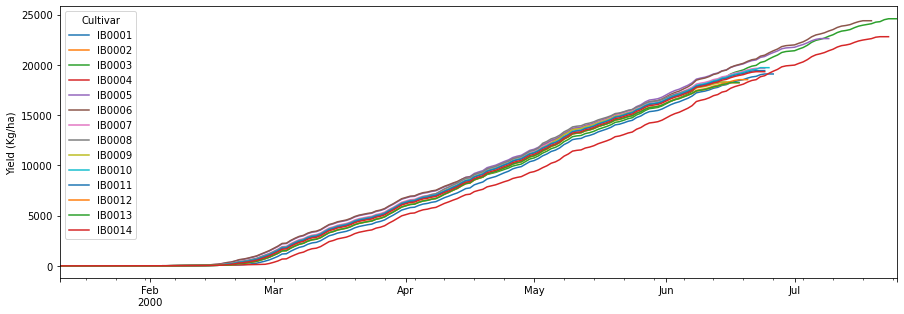

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))
for cultivar, df in output.items():
    df.CWAD.plot(ax=ax, label=cultivar)
ax.legend(title='Cultivar')
ax.set_ylabel('Yield (Kg/ha)')